# Detección de anomalías y técnicas de agrupamiento

## Prerrequisitos

In [34]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score  , log_loss , roc_auc_score

# Redes de neuronas
#Importing MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Revisión de datos

La cardiotocografía fetal (CTG) mide la frecuencia cardíaca del bebé (feto) durante el embarazo o el trabajo de parto y el parto. Estas mediciones pueden ayudar a los profesionales de la salud a verificar el estado general del feto y a identificar las primeras señales de sufrimiento fetal.

El set de datos consiste en 2126 (CTGs) con sus respectivas características para diagnóstico. Cabe destacar una clasificación realizada por obstetras, morfología (A, B, C,...) y estado fetal (N, S, P) por lo que el set de datos se puede aplicar para experimentos de 10 clases o de 3 clases.


Features:<br>
FileName: nombre de fichero<br>
Date: fecha<br>
b: instante de inicio<br>
e: instante de fin<br>
LBE: línea base (medical expert)<br>
LB: línea base (SisPorto)<br>
AC: aceleraciones (SisPorto)<br>
FM: movimiento fetal (SisPorto)<br>
UC: contracciones uterinas (SisPorto)<br>
ASTV: porcentaje de tiempo con variabilidad de anormalidad de corto período(SisPorto)<br>
mSTV: valor medio de variabilidad de corto período (SisPorto)<br>
ALTV: porcentaje de tiempo con variabilidad de anormalidad de largo período(SisPorto)<br>
mLTV: valor medio de variabilidad de largo período (SisPorto)<br>
DL: desaceleración ligera<br>
DS: desaceleración severa<br>
DP: desaceleración prolongada<br>
DR: desaceleración repetitiva<br>
Width: ancho de histograma<br>
Min: frecuencia baja de histograma<br>
Max: frecuencia alta de histograma<br>
Nmax: picos de histograma<br>
Nzeros: ceros de histograma<br>
Mode: moda de histograma<br>
Mean: media de histograma<br>
Median: mediana de histograma<br>
Variance: varianza de histograma<br>
Tendency: tendencia de histograma: -1=izquierda; 0=simétrica; 1=derecha<br>
A: sueño calmado<br>
B: sueño REM<br>
C: vigilancia calmada <br>
D: vigilancia activa<br>
SH: patrón de cambios (A or Susp con cambios)<br>
AD: patrón aceleración/desaceleración (estrés)<br>
DE: patrón desaceleración (vagal stimulation)<br>
LD: patrón desaceleración largo<br>
FS: patrón sinusoide-plano (estado patológico)<br>
SUSP: patrón sospechoso<br>
CLASS: código de clase (1 a 10) para clases A hasta SUSP<br>
NSP:- Normal=1; Sospechoso=2; Patológico=3<br>

In [35]:
#Visualizar más columnas en python
pd.options.display.max_columns = 40

# obtener datos
datos = pd.read_csv('CTG.csv')
datos.head(15)

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,0.0,0.0,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,0.0,0.0,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,0.0,0.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,0.0,0.0,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
5,Fmcs_2.txt,5/3/1996,CTG0006.txt,0.0,953.0,134.0,134.0,1.0,0.0,10.0,26.0,5.9,0.0,0.0,9.0,0.0,2.0,0.0,150.0,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,3.0
6,Fmcs_2.txt,5/3/1996,CTG0007.txt,240.0,953.0,134.0,134.0,1.0,0.0,9.0,29.0,6.3,0.0,0.0,6.0,0.0,2.0,0.0,150.0,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,3.0
7,Hasc_1.txt,2/22/1995,CTG0008.txt,62.0,679.0,122.0,122.0,0.0,0.0,0.0,83.0,0.5,6.0,15.6,0.0,0.0,0.0,0.0,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,3.0
8,Hasc_1.txt,2/22/1995,CTG0009.txt,120.0,779.0,122.0,122.0,0.0,0.0,1.0,84.0,0.5,5.0,13.6,0.0,0.0,0.0,0.0,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,3.0
9,Hasc_1.txt,2/22/1995,CTG0010.txt,181.0,1192.0,122.0,122.0,0.0,0.0,3.0,86.0,0.3,6.0,10.6,0.0,0.0,0.0,0.0,68.0,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,3.0


In [36]:
# eliminar columnas irrelevantes para el procesamiento

datos = datos.drop(["FileName","Date","SegFile","b","e"],axis=1)

### Acerca de los datos

Además de los datos propios del tipo de examen CTG, podemos observar que existen varios datos estadísticos asociados a cada muestra, lo que hace pensar que el examen no es de tipo instantáneo, sino de tipo continuo, realizado en un período de tiempo. Encontramos estadísticas del histograma de cada muestra. Más adelante se determinará si tiene sentido que formen parte del procesamiento.

In [37]:
datos.columns

Index(['LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode',
       'Mean', 'Median', 'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD',
       'DE', 'LD', 'FS', 'SUSP', 'CLASS', 'NSP'],
      dtype='object')

In [38]:
# Análisis de valores nulos

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2126 non-null   float64
 1   LB        2126 non-null   float64
 2   AC        2126 non-null   float64
 3   FM        2127 non-null   float64
 4   UC        2127 non-null   float64
 5   ASTV      2127 non-null   float64
 6   MSTV      2127 non-null   float64
 7   ALTV      2127 non-null   float64
 8   MLTV      2127 non-null   float64
 9   DL        2128 non-null   float64
 10  DS        2128 non-null   float64
 11  DP        2128 non-null   float64
 12  DR        2128 non-null   float64
 13  Width     2126 non-null   float64
 14  Min       2126 non-null   float64
 15  Max       2126 non-null   float64
 16  Nmax      2126 non-null   float64
 17  Nzeros    2126 non-null   float64
 18  Mode      2126 non-null   float64
 19  Mean      2126 non-null   float64
 20  Median    2126 non-null   floa

In [39]:
datos.isnull().sum()

LBE         3
LB          3
AC          3
FM          2
UC          2
ASTV        2
MSTV        2
ALTV        2
MLTV        2
DL          1
DS          1
DP          1
DR          1
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
A           3
B           3
C           3
D           3
E           3
AD          3
DE          3
LD          3
FS          3
SUSP        3
CLASS       3
NSP         3
dtype: int64

### Análisis de valores nulos

Se realizó una validación de los registros del dataset y se encontraron 3 registros con la mayor parte de variables en nulo, por lo que se eliminarán del conjunto a procesar

In [7]:
datos.tail(15)

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2114,137.0,137.0,0.0,0.0,6.0,81.0,0.4,33.0,6.3,0.0,0.0,0.0,0.0,31.0,121.0,152.0,2.0,0.0,146.0,143.0,145.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2115,140.0,140.0,0.0,0.0,3.0,83.0,0.2,48.0,5.4,0.0,0.0,0.0,0.0,20.0,132.0,152.0,2.0,0.0,145.0,145.0,146.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2116,140.0,140.0,1.0,0.0,1.0,80.0,0.2,36.0,2.2,0.0,0.0,0.0,0.0,18.0,140.0,158.0,1.0,0.0,147.0,148.0,149.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
2117,140.0,140.0,0.0,0.0,6.0,79.0,0.3,20.0,8.5,0.0,0.0,0.0,0.0,26.0,124.0,150.0,1.0,0.0,144.0,143.0,145.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2118,140.0,140.0,0.0,0.0,7.0,79.0,0.5,26.0,7.0,1.0,0.0,0.0,0.0,21.0,129.0,150.0,1.0,0.0,145.0,142.0,145.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2119,140.0,140.0,0.0,0.0,6.0,79.0,0.6,27.0,6.4,1.0,0.0,0.0,0.0,26.0,124.0,150.0,1.0,0.0,144.0,141.0,145.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2120,140.0,140.0,0.0,0.0,4.0,77.0,0.7,17.0,6.0,1.0,0.0,0.0,0.0,31.0,124.0,155.0,2.0,0.0,145.0,143.0,145.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2121,140.0,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,0.0,0.0,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2122,140.0,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,0.0,0.0,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2123,140.0,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,0.0,0.0,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0


In [8]:
# eliminar registros irrelevantes para el procesamiento
# indices 2126 2127 2128

# dropping multiple rows 
# removing odd indexes inrange 0-10
# displaying first 10 rows
# you can notice that odd rows are missing 

datos = datos.drop([2126,2127,2128])

In [9]:
datos.isnull().sum()

LBE         0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
DR          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
A           0
B           0
C           0
D           0
E           0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [10]:
# descripción de los datos
datos.describe(include = 'all')

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.0,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,9.84666,8.187629,1.570085,0.003293,0.126058,0.0,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,0.180621,0.272342,0.024929,0.038100,0.033866,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,9.840844,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,18.39688,5.628247,2.499229,0.057300,0.464361,0.0,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.384794,0.445270,0.155947,0.191482,0.180928,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,126.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,0.000000,0.000000,0.0,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,133.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,0.000000,0.000000,0.0,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,140.000000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.00000,10.800000,3.000000,0.000000,0.000000,0.0,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,160.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.00000,50.700000,16.000000,1.000000,4.000000,0.0,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000


In [11]:
datos['CLASS'].value_counts()

2.0     579
1.0     384
6.0     332
7.0     252
10.0    197
8.0     107
4.0      81
5.0      72
9.0      69
3.0      53
Name: CLASS, dtype: int64

In [12]:
datos['NSP'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: NSP, dtype: int64

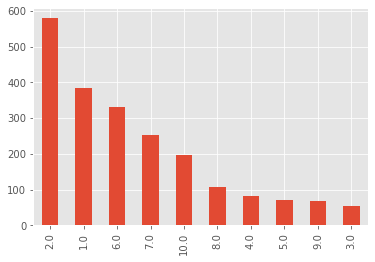

In [13]:
datos['CLASS'].value_counts().plot(kind='bar')#,autopct='%.2f',)
plt.show()

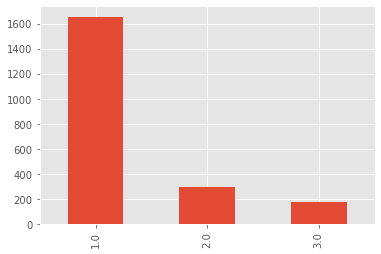

In [14]:
datos['NSP'].value_counts().plot(kind='bar')
plt.show()

In [15]:
# crear la matriz de correlación
corr = datos.corr()
corr

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
LBE,1.000000,1.000000,-0.077967,-0.033305,-0.127722,0.305570,-0.279607,0.285630,-0.032091,-0.155908,-0.053518,-0.117133,NaN,-0.147679,0.361619,0.275110,-0.113933,-0.004745,0.708993,0.723121,0.789246,-0.133938,0.293503,-0.023075,-0.048750,-0.062894,0.005591,0.158350,-0.130368,-0.030849,-0.122136,0.069885,0.283783,0.143001,0.148151
LB,1.000000,1.000000,-0.077967,-0.033305,-0.127722,0.305570,-0.279607,0.285630,-0.032091,-0.155908,-0.053518,-0.117133,NaN,-0.147679,0.361619,0.275110,-0.113933,-0.004745,0.708993,0.723121,0.789246,-0.133938,0.293503,-0.023075,-0.048750,-0.062894,0.005591,0.158350,-0.130368,-0.030849,-0.122136,0.069885,0.283783,0.143001,0.148151
AC,-0.077967,-0.077967,1.000000,0.053956,0.212100,-0.197985,0.191378,-0.345162,-0.128901,-0.011350,-0.039341,-0.110317,NaN,0.291516,-0.157447,0.373493,0.191475,-0.011430,0.221693,0.236811,0.250729,0.111981,0.032235,-0.315433,0.467663,-0.113805,0.328854,-0.116153,0.264657,-0.255090,-0.140998,-0.140062,-0.238009,-0.255205,-0.340394
FM,-0.033305,-0.033305,0.053956,1.000000,-0.036626,-0.116461,0.138061,-0.072214,0.021031,0.076283,-0.010328,0.205337,NaN,0.171448,-0.158422,0.111228,0.183904,-0.014632,-0.037492,-0.085718,-0.056281,0.177793,-0.000069,-0.077368,-0.053710,-0.022823,0.058019,-0.024547,0.113454,0.001145,0.089162,-0.003765,-0.033851,0.077805,0.060366
UC,-0.127722,-0.127722,0.212100,-0.036626,1.000000,-0.079651,0.232687,-0.247513,-0.106590,0.339484,0.018405,0.152395,NaN,0.152990,-0.112597,0.146645,0.095512,0.022701,-0.077695,-0.169739,-0.111041,0.184188,-0.060995,-0.042272,0.023350,-0.097485,-0.029741,-0.026050,0.243954,0.084710,0.113672,-0.205653,-0.251330,-0.073465,-0.163295
ASTV,0.305570,0.305570,-0.197985,-0.116461,-0.079651,1.000000,-0.430705,0.459413,-0.315105,-0.037040,0.033949,0.053677,NaN,-0.260463,0.275378,-0.111806,-0.167561,-0.149296,0.058363,0.074554,0.119960,-0.146434,-0.005748,0.046221,-0.139987,-0.142252,-0.113669,0.072269,-0.198840,-0.132195,0.137192,0.308643,0.364282,0.284580,0.471191
MSTV,-0.279607,-0.279607,0.191378,0.138061,0.232687,-0.430705,1.000000,-0.470259,0.073892,0.516901,0.034130,0.287548,NaN,0.660847,-0.622569,0.409072,0.501430,0.266183,-0.307586,-0.445401,-0.336109,0.555852,-0.066140,-0.242157,-0.045688,0.021396,0.096120,-0.126216,0.284401,0.259776,0.275303,-0.210904,-0.329125,0.077214,-0.103382
ALTV,0.285630,0.285630,-0.345162,-0.072214,-0.247513,0.459413,-0.470259,1.000000,-0.171114,-0.266298,-0.030770,-0.140133,NaN,-0.451297,0.422834,-0.283183,-0.279301,-0.121784,0.165211,0.222321,0.186480,-0.281536,0.042481,0.131350,-0.240259,-0.074120,-0.106547,0.075927,-0.205648,-0.117518,-0.123011,0.478205,0.446388,0.303050,0.426146
MLTV,-0.032091,-0.032091,-0.128901,0.021031,-0.106590,-0.315105,0.073892,-0.171114,1.000000,-0.251442,-0.037667,-0.230849,NaN,0.110942,-0.144976,0.002023,0.056357,0.123869,0.072071,0.137813,0.063228,-0.164079,0.153093,0.091077,0.117711,0.259315,-0.094099,0.045238,-0.082898,-0.022701,-0.225276,-0.104933,-0.044011,-0.228310,-0.226797
DL,-0.155908,-0.155908,-0.011350,0.076283,0.339484,-0.037040,0.516901,-0.266298,-0.251442,1.000000,0.121617,0.294068,NaN,0.520656,-0.539125,0.242187,0.393860,0.208487,-0.315463,-0.509446,-0.353878,0.515130,-0.000687,-0.263220,-0.321418,-0.090816,-0.112276,-0.108282,0.430801,0.446887,0.332372,-0.114025,-0.185229,0.395887,0.065328


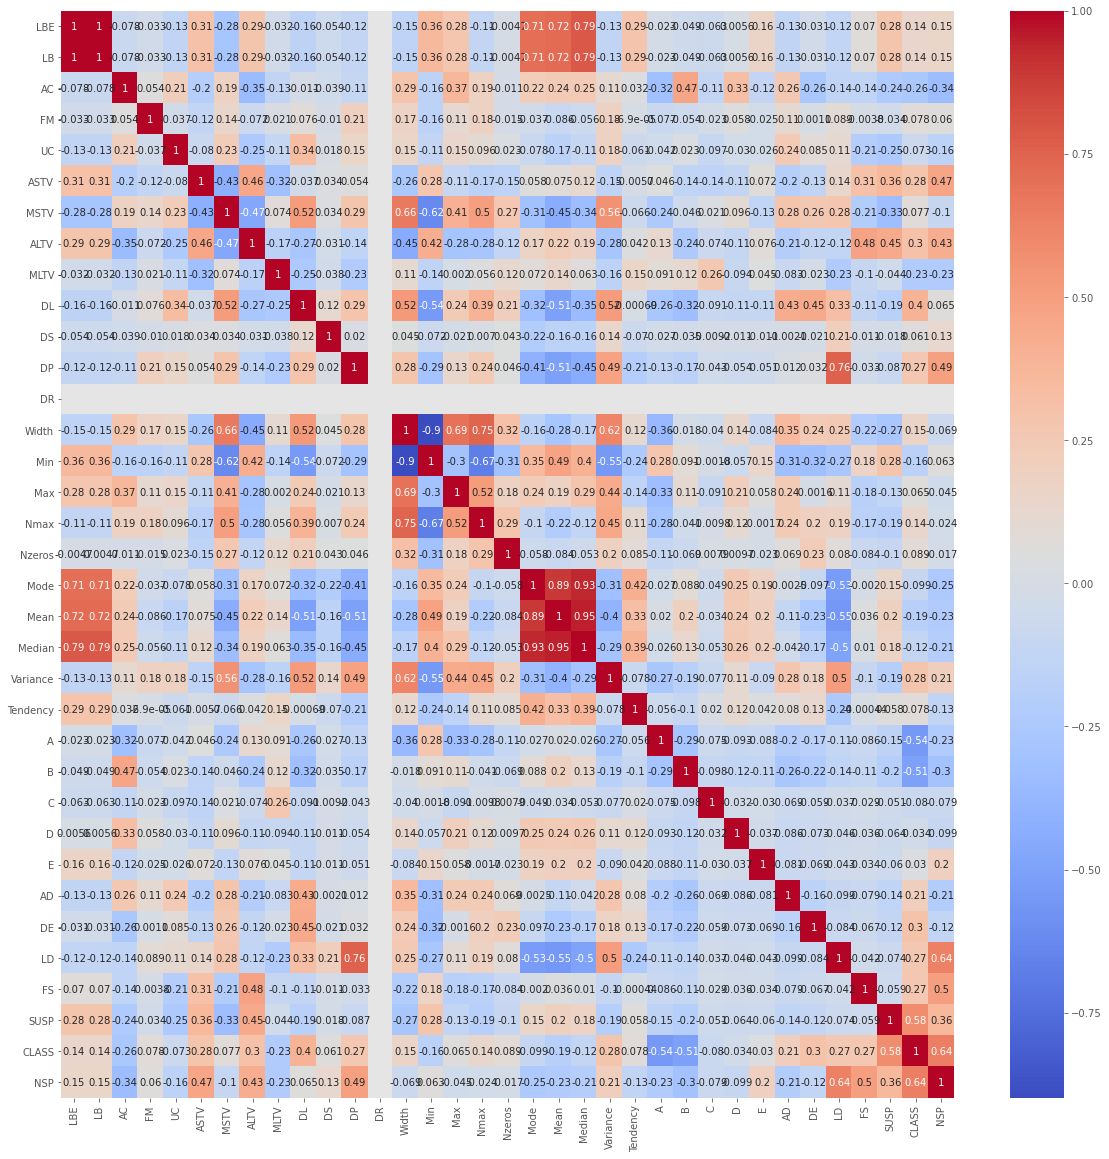

In [16]:
fig, ax = plt.subplots(figsize=(20,20)) 

# genera mapa de calor matriz de correlación. 
dataplot = sns.heatmap(datos.corr(), cmap="coolwarm", annot=True, ax=ax)

# presenta el mapa de calor
plt.show()

### Análisis de correlación

Luego de revisar los valores de la matriz de correlación, se identifican las siguientes variables como candidatas a eliminación:<br>

LBE - LB<br>
Width - Min<br>
Mode - Mean - Media<br>

Adicionalmente, vemos que la variable DR no presenta valores, y revisando el dataset, para todas las muestras presenta un valor de 0.0, por lo que se considera la eliminación

In [17]:
# eliminar columnas altamente correlacionadas

datos = datos.drop(["LB","Width","Mode","Median"],axis=1)

In [18]:
# eliminar columnas sin datos significativos

datos = datos.drop(["DR"],axis=1)

## Detección de anomalías

In [19]:
# descripción de los datos
datos.describe(include = 'all')

,LBE,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Min,Max,Nmax,Nzeros,Mean,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,9.84666,8.187629,1.570085,0.003293,0.126058,93.579492,164.025400,4.068203,0.323612,134.610536,18.808090,0.320320,0.180621,0.272342,0.024929,0.038100,0.033866,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,18.39688,5.628247,2.499229,0.057300,0.464361,29.560212,17.944183,2.949386,0.706059,15.593596,28.977636,0.610829,0.384794,0.445270,0.155947,0.191482,0.180928,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,0.000000,0.000000,50.000000,122.000000,0.000000,0.000000,73.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,0.000000,0.000000,67.000000,152.000000,2.000000,0.000000,125.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,0.000000,0.000000,93.000000,162.000000,3.000000,0.000000,136.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.00000,10.800000,3.000000,0.000000,0.000000,120.000000,174.000000,6.000000,0.000000,145.000000,24.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.00000,50.700000,16.000000,1.000000,4.000000,159.000000,238.000000,18.000000,10.000000,182.000000,269.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000


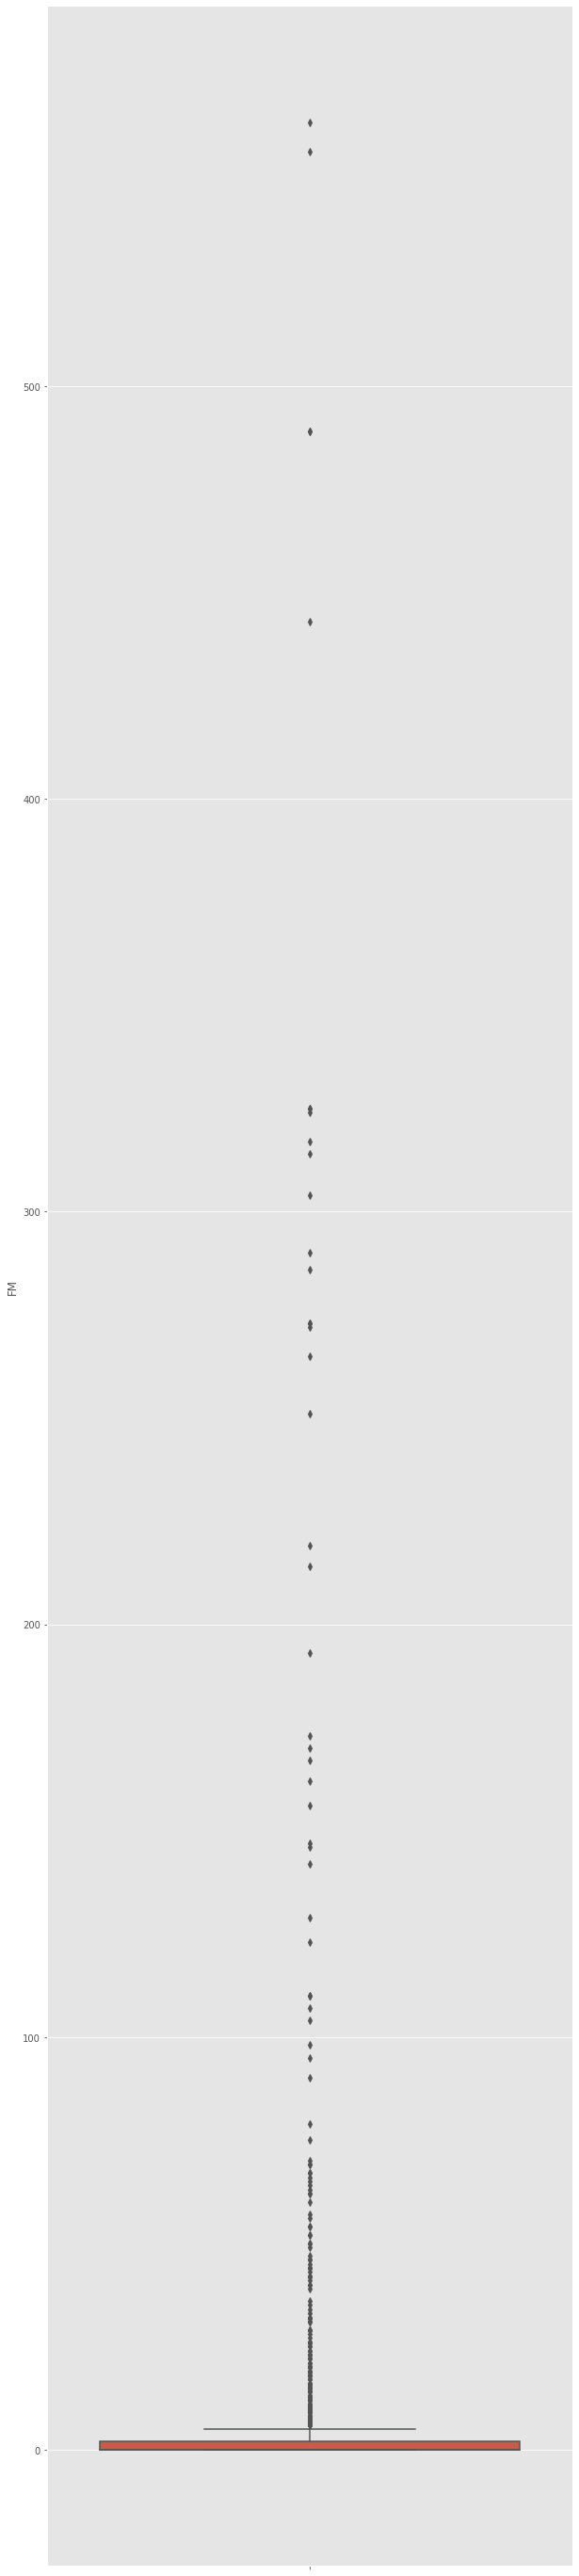

In [20]:
import seaborn as sns

plt.figure(figsize=(10,50))
ax = sns.boxplot(y = datos['FM']) #, whis = 0.99)


In [17]:
# Método intercuartil
# En este caso, nos interesa solamente el límite superior, ya que la escala de valores 
# parte de 0.0 para las variables analizadas

def out_iqr(df , column, upper_limit):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], upper_limit)
    # IQR
    iqr = q75
    # outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value    
    upper = q75 + cut_off
    print('IQR',iqr)
    print('El limite superior es', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    return print('Número total de outliers detectados', df1.shape[0])

In [18]:
out_iqr(datos,'FM', 0.98)

IQR 68.0
El limite superior es 170.0
Número total de outliers detectados 22


In [19]:
out_iqr(datos,'AC', 0.9)

IQR 8.0
El limite superior es 20.0
Número total de outliers detectados 2


In [20]:
out_iqr(datos,'UC', 0.9)

IQR 7.0
El limite superior es 17.5
Número total de outliers detectados 1


## Agrupamiento

Para el proceso de agrupamiento, es útil apoyarnos en los dendogramas del dataset utilizado

In [30]:
# prerequisitos para agrupamiento

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

In [31]:
# estructuramos los datasets para clasificación
# seleccionamos solamente los campos relevantes proporcionados por los indicadores del CTG
# descartamos los datos estadísticos del histograma de cada muestra

X=datos[['LBE', 'AC', 'FM', 'UC', 'DL','DS', 'DP', 'AD', 'LD', 'A', 'B']]
Y=datos[['NSP']]

In [23]:
# aplicamos escalamiento de datos numéricos

Scaler=StandardScaler()
X=Scaler.fit_transform(X)

In [24]:
# estructuramos conjuntos de entrenamiento 90-10
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.1)

In [25]:
# aplicamos SVM y la predicción sobre el conjunto de test
svm_clf=SVC(kernel="poly",degree=6,coef0=5,gamma=0.1)
svm_clf=svm_clf.fit(X_train,y_train)
y_pred=svm_clf.predict(X_test)

In [26]:
# obtenemos el score ponderado
f1_score(y_test,y_pred,average='weighted')

0.9525618465478005

Podemos observar el agrupamiento de los datos en los distintos grupos obtenidos (cada grupo de color distinto)


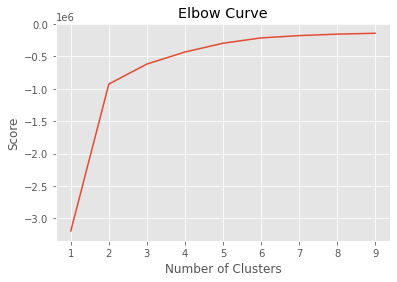

In [41]:
from sklearn.cluster import KMeans
#Método para determinar el mejor valor de K
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [42]:
# 3 es un buen valor, se identifican los centroides para cada clase
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)


[[ 1.29736842e+02  4.73684211e+00  1.05631579e+02  2.55263158e+00
   2.86842105e+00  4.33680869e-19  4.21052632e-01  2.10526316e-01
   1.57894737e-01 -2.77555756e-17  2.10526316e-01]
 [ 1.31111111e+02  3.22222222e+00  3.53388889e+02  3.61111111e+00
   3.16666667e+00  4.33680869e-19  1.00000000e+00  6.66666667e-01
   1.66666667e-01 -2.77555756e-17  5.55111512e-17]
 [ 1.33388406e+02  2.68115942e+00  2.42512077e+00  3.68067633e+00
   1.53236715e+00  3.38164251e-03  1.13043478e-01  1.50724638e-01
   4.73429952e-02  1.85507246e-01  2.75845411e-01]]


## Referencias bibliográficas

SciPy Hierarchical Clustering and Dendrogram Tutorial<br>
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/<br>

In Depth: k-Means Clustering
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

Clustering With K-Means in Python
https://datasciencelab.wordpress.com/2013/12/12/clustering-with-k-means-in-python/

Finding the K in K-Means Clustering
https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/

Improved Seeding For Clustering With K-Means++
https://datasciencelab.wordpress.com/2014/01/15/improved-seeding-for-clustering-with-k-means/

Selection of K in K-means Clustering, Reloaded
https://datasciencelab.wordpress.com/2014/01/21/selection-of-k-in-k-means-clustering-reloaded/


Nicolas Kruchten's presentation at Montreal Python 50
https://github.com/datacratic/mtlpy50

scipy.cluster.hierarchy.linkage
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

2.7. Novelty and Outlier Detection
https://scikit-learn.org/stable/modules/outlier_detection.html

